# Gauss-Newton Method for Polynomial Fitting

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(6)
np.random.seed(6)

## Generate synthetic data


In [2]:

theta_true = torch.tensor([1.5, -4.7, -8.7, -0.4, 6.4], dtype=torch.float32)
X = torch.linspace(-10, 10, 1000)

# scale X
X_mean = X.mean()
X_std = X.std()
X_scaled = (X - X_mean) / X_std

X = X_scaled

# Compute true Y values (without noise)
Y_true = theta_true[0]*X**4 + theta_true[1]*X**3 + theta_true[2]*X**2 + theta_true[3]*X + theta_true[4]

print(f"First ten entries of X: {X[:10]}")
print(f"First 10 entries of Y_true: {Y_true[:10]}")
print(f"True theta: {theta_true}")


First ten entries of X: tensor([-1.7295, -1.7260, -1.7225, -1.7191, -1.7156, -1.7121, -1.7087, -1.7052,
        -1.7018, -1.6983])
First 10 entries of Y_true: tensor([18.8015, 18.6513, 18.5021, 18.3540, 18.2069, 18.0608, 17.9157, 17.7715,
        17.6284, 17.4863])
True theta: tensor([ 1.5000, -4.7000, -8.7000, -0.4000,  6.4000])


## Construct experimental data with noise

In [3]:

# Add Gaussian noise to Y
noise_std = Y_true.abs().mean() * 0.1 
Y_noisy = Y_true + torch.randn_like(Y_true) * noise_std
print(f"First 10 entries of Y after adding gaussian noise: {Y_noisy[:10]}")

# Initialize theta for Gauss-Newton method from [-1,1]
# theta = torch.zeros(5, dtype=torch.float32)
theta = torch.rand(5, dtype=torch.float32)*2 - 1
print(f"initial value of theta: {theta}")

# # Define the LambdaEstimator using LSTM
# class LambdaEstimator(nn.Module):
#     def __init__(self, input_size=1, hidden_size=5, num_layers=2):
#         super(LambdaEstimator, self).__init__()
#         self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc1 = nn.Linear(hidden_size, 10)
#         self.fc2 = nn.Linear(10, 1)
# 
#     def forward(self, x):
#         # x should be of shape (batch_size, seq_len, input_size)
#         out, _ = self.rnn(x)
#         out = self.fc1(out[:, -1, :])  # Use the last output
#         out = self.fc2(out)
#         return out


# Define the LambdaEstimator using a vanilla RNN
class LambdaEstimator(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers=2):
        super(LambdaEstimator, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        # x should be of shape (batch_size, seq_len, input_size)
        out, _ = self.rnn(x)
        out = self.fc1(out[:, -1, :])  # Use the last output
        out = self.fc2(out)
        return out
    
# Initialize the LambdaEstimator and its optimizer
lambda_estimator = LambdaEstimator()
optimizer_lambda = optim.Adam(lambda_estimator.parameters(), lr=1e-2)



First 10 entries of Y after adding gaussian noise: tensor([17.7995, 19.1727, 17.2852, 17.2496, 17.8019, 18.1697, 18.1882, 18.0415,
        17.2309, 18.3988])
initial value of theta: tensor([ 0.8906,  0.0986,  0.2284,  0.7118, -0.8600])


## Gauss-Newton iterations with adaptive lambda


In [4]:

max_iters = 10
losses = []
epsilon = 1e-10 # to check for convergence

for iteration in range(max_iters):
        #ensure theta requires grad
        theta = theta.detach().requires_grad_(True)
    
        # predict Y using current estimate of theta
        Y_pred = (theta[0]*X**4 + theta[1]*X**3 + theta[2]*X**2 +
                  theta[3]*X + theta[4])
        residuals = Y_pred - Y_noisy 
    
        # Reshape residuals for LambdaEstimator using RNN
        residuals_input = residuals.view(1, -1, 1)  # Shape: [batch_size=1, seq_len=N, input_size=1]
    
        # Estimate lambda using the RNN
        lambda_output = lambda_estimator(residuals_input)
        #ensure lambda is positive so that hessian is positive definite
        lambda_value = torch.exp(lambda_output).squeeze()
    
        # compute Jacobian matrix J
        #partial derivatives of  Y_{pred}  with respect to each theta_i  are
        J = torch.stack([X**4, X**3, X**2, X, torch.ones_like(X)], dim=1)
    
        # Compute Hessian approximation H = J^T * J + lambda * I
        JTJ = J.T @ J  # Shape: [5, 5]
        H = JTJ + lambda_value * torch.eye(5)
    
        # Compute J^T * residuals
        JTr = J.T @ residuals  # Shape: [5]
        H_inv = torch.inverse(H)
        delta_theta = H_inv @ JTr    
        theta = theta - delta_theta
    
        #retain gradients for lambda_value
        lambda_value.retain_grad()
    
        # compute loss(sum of squared residuals) with regularization term
        loss = torch.sum(residuals**2)  + 0.5*torch.norm(theta)**2
        losses.append(loss.item())
        optimizer_lambda.zero_grad()
        loss.backward()
    
        # Check if gradients are flowing back
        print("Lambda gradient:", lambda_value.grad.item())
    
        # Update LambdaEstimator parameters
        optimizer_lambda.step()
    
        # Print iteration details
        print(f"Iteration {iteration+1}, Loss: {loss.item():.4e}, Lambda: {lambda_value.item():.4e}, ||delta_theta||: {delta_theta.norm().item():.4e}")
    
        # Check for convergence by looking at the norm of delta_theta
        if delta_theta.norm().item() < epsilon:
            print(f"Norm of delta theta is less than threshold of {epsilon}. Convergence achieved!!")
            break
            
     

Lambda gradient: -2.0373497009277344
Iteration 1, Loss: 1.5314e+05, Lambda: 1.5388e+00, ||delta_theta||: 1.2374e+01
Lambda gradient: -0.05979401245713234
Iteration 2, Loss: 7.4616e+02, Lambda: 1.5453e+00, ||delta_theta||: 3.0198e-01
Lambda gradient: -0.0017225195188075304
Iteration 3, Loss: 7.4118e+02, Lambda: 1.7596e+00, ||delta_theta||: 8.7360e-03
Lambda gradient: -5.639602750306949e-05
Iteration 4, Loss: 7.4118e+02, Lambda: 1.9500e+00, ||delta_theta||: 2.8718e-04
Lambda gradient: -1.9523083665262675e-06
Iteration 5, Loss: 7.4118e+02, Lambda: 2.1278e+00, ||delta_theta||: 9.9699e-06
Lambda gradient: -1.2140230865043122e-07
Iteration 6, Loss: 7.4118e+02, Lambda: 2.2956e+00, ||delta_theta||: 6.3847e-07
Lambda gradient: 5.71976457308665e-08
Iteration 7, Loss: 7.4118e+02, Lambda: 2.4545e+00, ||delta_theta||: 3.7123e-07
Lambda gradient: 5.249798817885676e-08
Iteration 8, Loss: 7.4118e+02, Lambda: 2.6050e+00, ||delta_theta||: 3.4446e-07
Lambda gradient: 4.547871412796667e-08
Iteration 9, Lo

## Visualization of Loss and Fitted Polynomial

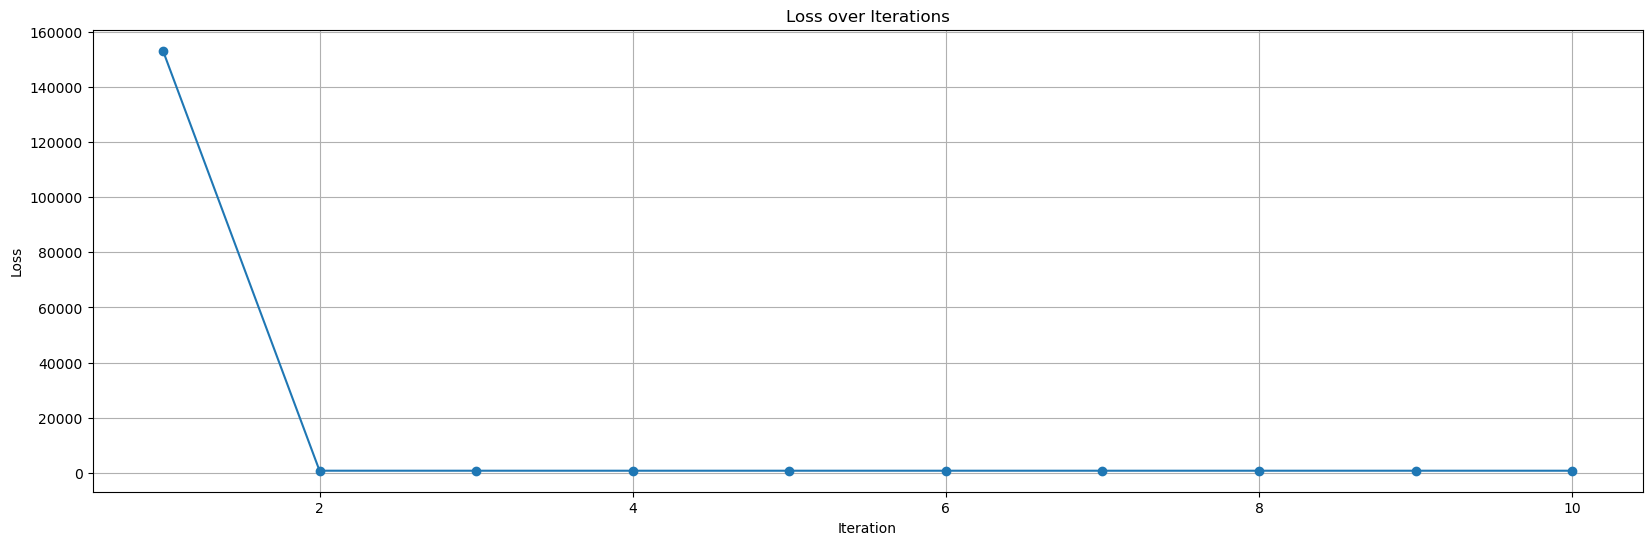

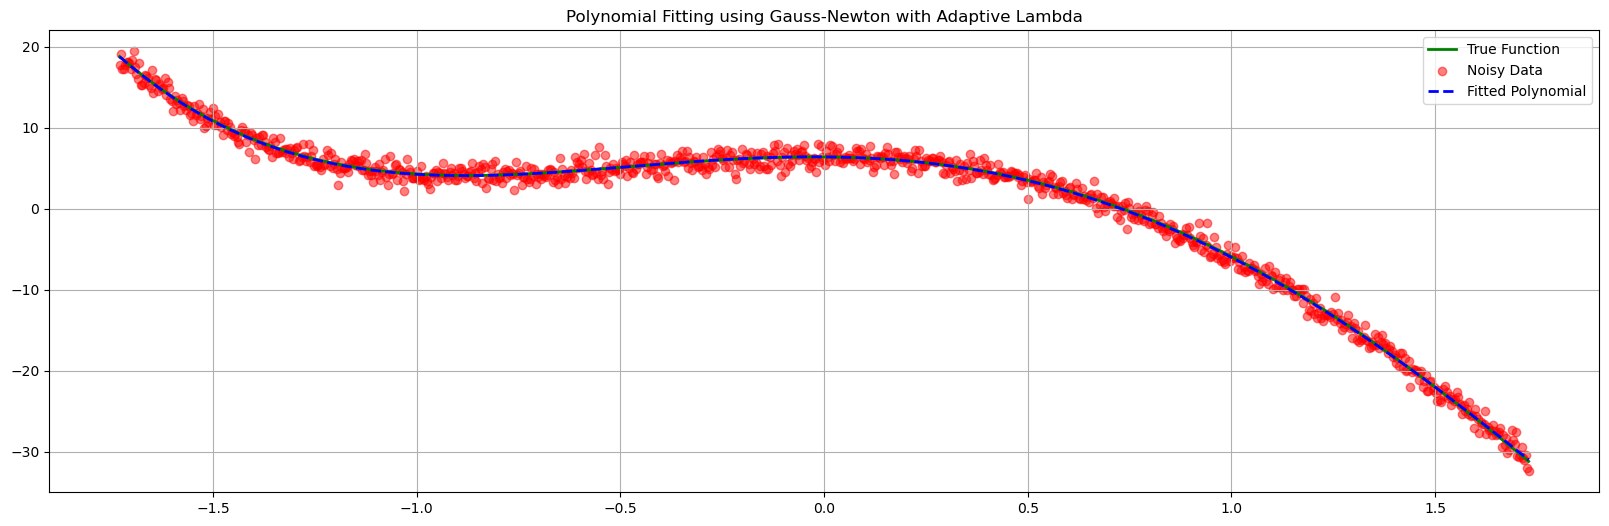

Estimated theta: [ 1.5599806 -4.6522965 -8.85258   -0.4805224  6.413221 ]
True theta: [ 1.5 -4.7 -8.7 -0.4  6.4]


In [5]:
       
# Plot the loss over iterations
plt.figure(figsize=(20, 6))
plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.grid(True)
plt.show()

# Plot the original data, noisy data, and the fitted polynomial
plt.figure(figsize=(20, 6))
plt.plot(X, Y_true, label='True Function', color='green', linewidth=2)
plt.scatter(X, Y_noisy, label='Noisy Data', color='red', alpha=0.5)
Y_fitted = (theta[0]*X**4 + theta[1]*X**3 + theta[2]*X**2 +  theta[3]*X + theta[4])


plt.plot(X, Y_fitted.detach(), label='Fitted Polynomial', linestyle='--', color='blue', linewidth=2)
plt.legend()

plt.title('Polynomial Fitting using Gauss-Newton with Adaptive Lambda')

plt.grid(True)
plt.show()

# Print the estimated and true theta values
print(f"Estimated theta: {theta.detach().numpy()}")
print(f"True theta: {theta_true.numpy()}")
